In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time
import pylab as pl
from IPython import display
from parameters import *
from micro import *
from aero_init import *
from parcel import *
from condensation import *
from collision import *
from analysis import *
from print_plot import *

import itertools
import matplotlib

%load_ext autoreload
%autoreload 2

# Intialization
## Input parameter

In [2]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create the widgets for the variables
dt_widget      = widgets.BoundedFloatText(description='dt [s]:', min = 1.0, max = 5.0, value = 1.0)
nt_widget      = widgets.IntText(description='nt:', value = 3600)
N_aero1_widget = widgets.IntSlider(description='N_aero1:', min=0, max=5000, value=500)
N_aero2_widget = widgets.IntSlider(description='N_aero2:', min=0, max=5000, value=200)
Condensation_widget = widgets.Checkbox(description='Condensation:', value=True)
Collision_widget = widgets.Checkbox(description='Collision:', value=False)


n_particles_widget = widgets.IntSlider(description='n_particles:', min=10, max=1000, value=500)
collision_start_t_widget = widgets.BoundedIntText(description='collision start time [s]:', min = 0,max=10000,value = 0)

# max z insert again
max_z_widget = widgets.BoundedFloatText(description='z_max [m]:', min = 0.0, max = 1400.0, step = 0.1, value=1500.0)
# max value of collision_start_t_widget not updated when nt changed in the textbox! It remains at the default value of nt_widget

# Display the widgets
display('Model steering parameters',dt_widget, nt_widget, N_aero1_widget, N_aero2_widget,Condensation_widget,Collision_widget, n_particles_widget, collision_start_t_widget, max_z_widget) #button)

'Model steering parameters'

BoundedFloatText(value=1.0, description='dt [s]:', max=5.0, min=1.0)

IntText(value=3600, description='nt:')

IntSlider(value=500, description='N_aero1:', max=5000)

IntSlider(value=200, description='N_aero2:', max=5000)

Checkbox(value=True, description='Condensation:')

Checkbox(value=False, description='Collision:')

IntSlider(value=500, description='n_particles:', max=1000, min=10)

BoundedIntText(value=0, description='collision start time [s]:', max=10000)

BoundedFloatText(value=1400.0, description='z_max [m]:', max=1400.0, step=0.1)

In [3]:
# section for widgets for parcel info
T_widget = widgets.BoundedFloatText(description='T [K]:', min = 200.0, max = 320.0, step = 0.1, value=293.2)
P_widget = widgets.BoundedFloatText(description='P [Pa]:', min = 950.0E2, max = 1050.0E2, step = 1, value=1013.0E2)
RH_widget= widgets.BoundedFloatText(description='RH [-]:', min = 0.01, max = 0.99, step = 0.01, value=0.88)
w_widget = widgets.BoundedFloatText(description='w [m/s]:', min = 0.0, max = 10, step = 0.1, value=0.5)


# Display widgets
display('Parcel initial parameters: ', T_widget, P_widget, RH_widget, w_widget)

'Parcel initial parameters: '

BoundedFloatText(value=293.2, description='T [K]:', max=320.0, min=200.0, step=0.1)

BoundedFloatText(value=101300.0, description='P [Pa]:', max=105000.0, min=95000.0, step=1.0)

BoundedFloatText(value=0.88, description='RH [-]:', max=0.99, min=0.01, step=0.01)

BoundedFloatText(value=0.5, description='w [m/s]:', max=10.0, step=0.1)

In [4]:
# widgets for aerosol initialisation
mode_aero_init_widget = widgets.ToggleButtons(options=['weighting_factor', 'random'], value='weighting_factor', description='mode of aerosol init.:', layout={'width': 'max-content'}, disabled=False)
# nr of modes
#mode_nr_widget = widgets.IntSlider(value=2, min=2, max=5, step=1, description='nr. of modes:', disabled=False, readout=True, readout_format='d')

# Display widgets
display('Aerosol initialisation: ', mode_aero_init_widget)


'Aerosol initialisation: '

ToggleButtons(description='mode of aerosol init.:', layout=Layout(width='max-content'), options=('weighting_fa…

In [5]:
# N, mu, sigma for each mode
# widgets in GridspecLayout
# see: https://ipywidgets.readthedocs.io/en/latest/examples/Layout%20Templates.html#style-attributes
print('Please insert the parameters for each mode (=row). If you only want e.g. 2 modes, leave the last two rows empty')
print('Click on the heading buttons to plot the distributions of the respective modes.')
print('N_aero: number of aerosols per cubic centimeter, mu: mean droplet radius, sigma: std of mu')

gridwidget = widgets.GridspecLayout(4, 4)

# work in progress, values not yet adapted
# col 0 for mode 1
gridwidget[0, 0]= widgets.Button(description='Mode #1 (plot)', disabled=False, button_style='info', tooltip='Heading')
# idea: print distribution on clicking
# see: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#button
gridwidget[1, 0] = widgets.BoundedFloatText(description='N_aero[cm⁻3]', min = 0.0, max = 5000.0, step = 0.1, value=100.0)
# internally multiply this by 1E6
gridwidget[2, 0] = widgets.BoundedFloatText(description='mu [nm]', min = 0.0, max = 5000.0, step = 0.1, value=100.0)
# internally multiply this by 1E-9 and take the log
gridwidget[3, 0] = widgets.BoundedFloatText(description='sigma [?]', min = 0.0, max = 3.0, step = 0.1, value=2.0)
# internally take the log

# col 1 for mode 2
gridwidget[0, 1]= widgets.Button(description='Mode #2 (plot)', disabled=False, button_style='info', tooltip='Heading')

gridwidget[1, 1] = widgets.BoundedFloatText(description='N_aero[cm⁻3]', min = 0.0, max = 5000.0, step = 0.1, value=50.0)
# internally multiply this by 1E6
gridwidget[2, 1] = widgets.BoundedFloatText(description='mu [nm]', min = 0.0, max = 5000.0, step = 0.1, value=500.0)
# internally multiply this by 1E-9 and take the log
gridwidget[3, 1] = widgets.BoundedFloatText(description='sigma [-]', min = 0.0, max = 3.0, step = 0.1, value=1.5)
# internally take the log

# col 2 for mode 3
gridwidget[0, 2]= widgets.Button(description='Mode #3 (plot)', disabled=False, button_style='info', tooltip='Heading')

gridwidget[1, 2] = widgets.BoundedFloatText(description='N_aero[cm⁻3]', min = 0.0, max = 5000.0, step = 0.1, value=25.0)
# internally multiply this by 1E6
gridwidget[2, 2] = widgets.BoundedFloatText(description='mu [nm]', min = 0.0, max = 5000.0, step = 0.1, value=500.0)
# internally multiply this by 1E-9 and take the log
gridwidget[3, 2] = widgets.BoundedFloatText(description='sigma [-]', min = 0.0, max = 3.0, step = 0.1, value=1.2)
# internally take the log


# col 3 for mode 4
gridwidget[0, 3]= widgets.Button(description='Mode #4 (plot)', disabled=False, button_style='info', tooltip='Heading')

gridwidget[1, 3] = widgets.BoundedFloatText(description='N_aero[cm⁻3]', min = 0.0, max = 5000.0, step = 0.1, value=12.5)
# internally multiply this by 1E6
gridwidget[2, 3] = widgets.BoundedFloatText(description='mu [nm]', min = 0.0, max = 5000.0, step = 0.1, value=500.0)
# internally multiply this by 1E-9 and take the log
gridwidget[3, 3] = widgets.BoundedFloatText(description='sigma [-]', min = 0.0, max = 3.0, step = 0.1, value=1.0)
# internally take the log


# additional button in the end for the cumulative distr.
plotbutton_widget = widgets.Button(description='Plot cumulative distr.', disabled=False, button_style='info', tooltip='Plot cumulative distribution of all modes')

display(gridwidget, plotbutton_widget)

Please insert the parameters for each mode (=row). If you only want e.g. 2 modes, leave the last two rows empty
Click on the heading buttons to plot the distributions of the respective modes.
N_aero: number of aerosols per cubic centimeter, mu: mean droplet radius, sigma: std of mu


GridspecLayout(children=(Button(button_style='info', description='Mode #1 (plot)', layout=Layout(grid_area='wi…

Button(button_style='info', description='Plot cumulative distr.', style=ButtonStyle(), tooltip='Plot cumulativ…

In [8]:
# model steering parameters as read in above
dt = dt_widget.value #0.5
nt = nt_widget.value #100

do_condensation = Condensation_widget.value  #True
do_collision    = Collision_widget.value  #False


collision_start_time = collision_start_t_widget.value
n_particles = n_particles_widget.value


#parcel info. 
T_parcel   = T_widget.value
P_parcel   = P_widget.value
RH_parcel  = RH_widget.value
w_parcel   = w_widget.value
z_parcel   = 0.0 #m

# RH to q conversion
q_parcel    = RH_parcel * esatw( T_parcel ) / ( P_parcel - RH_parcel * esatw( T_parcel ) ) * r_a / rv

# new: max_z now depends on collision_start_time and w_parcel
# => strange results if collision_start_time is quite small
# changed back to manual max_z initialization
# max_z = collision_start_time * w_parcel 

#aerosol initialization
mode_aero_init = mode_aero_init_widget.value  # "weighting_factor", 'random'

N_aero =[100.0E6, 50.0E6]#[1e6*var3_widget.value,1e6*var4_widget.value ]#[100.0E6, 50.0E6]
mu_aero = [np.log(100.0E-9), np.log(500.0E-9)] # mean radius
sigma_aero = [np.log(2), np.log(1.5), np.log(1.2)] # std of radius

# if (any of the ) N_aero == 0 --> error, it should not start

# fixed parameters
rho_aero = 2170.0
molecular_weight_aero = 0.058443

if mode_aero_init == 'random':
    n_particles_mode1 = n_particles // 2  # Number of particles for the first mode
    n_particles_mode2 = n_particles - n_particles_mode1  # Number of particles for the second mode

    # Generate log-normal distribution for the first mode
    mode1_values = np.random.lognormal(mu_aero[0], sigma_aero[0], n_particles_mode1)

    # Generate log-normal distribution for the second mode
    mode2_values = np.random.lognormal(mu_aero[1], sigma_aero[1], n_particles_mode2)

    # Combine the values from both modes
    aero_r_seed = np.concatenate((mode1_values, mode2_values))
    


nbins = 100
log_edges = np.logspace(np.log10(0.1E-6), np.log10(1000.0E-6), nbins + 1)
spectra_arr = np.zeros((nt+1,nbins))

qa_ts,qc_ts,qr_ts = np.zeros(nt+1),np.zeros(nt+1),np.zeros(nt+1)
na_ts,nc_ts,nr_ts = np.zeros(nt+1),np.zeros(nt+1),np.zeros(nt+1)

# Time step routine

In [ ]:
dz=0
rho_parcel, V_parcel, air_mass_parcel =  parcel_rho(P_parcel, T_parcel)
#Aerosol init
T_parcel, q_parcel, particles_list = aero_init(mode_aero_init, n_particles, P_parcel, T_parcel,q_parcel, aero_r_seed,N_aero, mu_aero,sigma_aero,rho_aero,molecular_weight_aero)
#parcel routine
spectra_arr[0],qa_ts[0], qc_ts[0],qr_ts[0], na_ts[0], nc_ts[0], nr_ts[0] = qc_qr_analysis(particles_list,air_mass_parcel,log_edges)

#fig, ax = plt.subplots()
for t in range(nt):
    time = (t+1)*dt
    #Parcel ascending
    dz = w_parcel * dt
    if z_parcel < max_z: 
        z_parcel, T_parcel, rho_parcel, V_parcel, air_mass_parcel = ascend_parcel(z_parcel, T_parcel,P_parcel, dz)
    
    #Condensational Growth
    dq_liq = 0.0
    if do_condensation:
        particles_list, T_parcel, q_parcel = drop_condensation(particles_list, T_parcel, q_parcel, P_parcel, dt, air_mass_parcel, rho_aero, molecular_weight_aero)

    #Collisional Growth
    if do_collision and time > collision_start_time:
        particles_list = collection(dt, particles_list,rho_parcel, rho_liq, P_parcel, T_parcel)
    #Analysis
    spectra_arr[t+1],qa_ts[t+1], qc_ts[t+1],qr_ts[t+1], na_ts[t+1], nc_ts[t+1], nr_ts[t+1] = qc_qr_analysis(particles_list,air_mass_parcel,log_edges)
    
    #Visulaization at every second
    if (time%1) ==0:
        RH_parcel = (q_parcel * P_parcel / (q_parcel + r_a / rv)) / esatw( T_parcel ) 
        print_output(t,dt, z_parcel, T_parcel, q_parcel, RH_parcel, qc_ts[t+1], qr_ts[t+1], na_ts[t+1], nc_ts[t+1], nr_ts[t+1])
    #spec_plot(ax,spectra_arr, nt, log_edges)
    

value: Time (s)  z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg)
after: 287.0     0.00     293.21   12.95     87.950    0.002     0.000     652.59    159.82    0.00    


/project/meteo/work/J.Lim/PyLCM_parcel/print_plot.py:21: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(np.arange(nt+1)*dt, log_edges[1:], spectra_arr.T, norm=matplotlib.colors.LogNorm())


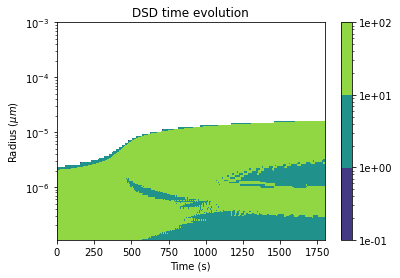

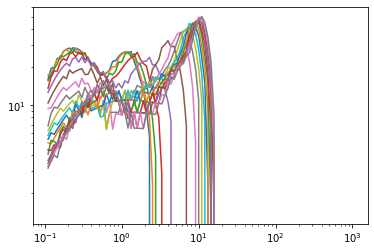

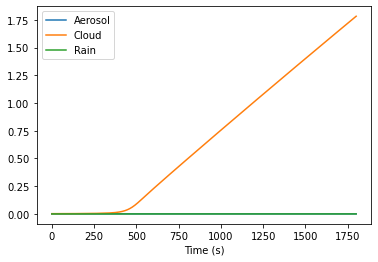

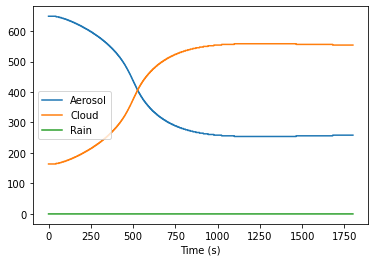

In [25]:
fig, ax = plt.subplots()
spec_plot(ax,spectra_arr/1e6, nt,dt,log_edges)

for i in range(18):
    plt.plot(log_edges[1:]*1e6, spectra_arr[i*100]/1e6)
    plt.yscale("log")
    plt.xscale("log")

plt.figure()
plt.plot(np.arange(nt+1),qa_ts*1e3, label = "Aerosol")
plt.plot(np.arange(nt+1),qc_ts*1e3, label = "Cloud")
plt.plot(np.arange(nt+1),qr_ts*1e3, label = "Rain")
plt.xlabel("Time (s)")
plt.legend()

plt.figure()
plt.plot(np.arange(nt+1),na_ts/1e6, label = "Aerosol")
plt.plot(np.arange(nt+1),nc_ts/1e6, label = "Cloud")
plt.plot(np.arange(nt+1),nr_ts/1e6, label = "Rain")
plt.xlabel("Time (s)")
plt.legend()